# Notebook to compute the state evolution for ridge regression and different resampling

**Pour ridge regression, le lambda optimal est constant a $\sigma^2$**

TODO : Add the plots + state evolution to compute the bias

In [51]:
using BootstrapAsymptotics
using ProgressBars
using JSON
using Revise
using StableRNGs

using Colors
using Plots
using ProgressMeter
using Statistics

In [52]:
alpha_range    = exp10.(range(-1.0, stop=3.0, length=50))
lambda         = 0.01
noise_variance = 1.0
max_weight     = 20
rtol           = 1e-20
max_iteration  = 10000

10000

In [61]:
algos = [
    PairBootstrap(10),
    ResidualBootstrap(),
    Subsampling(0.8),
    Subsampling(0.99),
    BayesOpt(),
    # 
    FullResampling(),
    LabelResampling(),

]

filenames = Dict(
    PairBootstrap(10) => "data/ridge/ridge_pair_bootstrap_overlaps_lambda=$lambda.json",
    ResidualBootstrap() => "data/ridge/ridge_residual_bootstrap_overlaps_lambda=$lambda.json",
    Subsampling(0.8) => "data/ridge/ridge_subsampling_08_overlaps_lambda=$lambda.json",
    Subsampling(0.99) => "data/ridge/ridge_subsampling_099_overlaps_lambda=$lambda.json",
    FullResampling() => "data/ridge/ridge_full_resampling_overlaps_lambda=$lambda.json",
    LabelResampling() => "data/ridge/ridge_label_resampling_overlaps_lambda=$lambda.json",
    BayesOpt() => "data/ridge/ridge_bayes_optimal_overlaps_lambda=$lambda.json",
)

exp_filenames = Dict(
    PairBootstrap(10)   => "data/ridge/exp_ridge_pair_bootstrap_bias_variance_lambda=$lambda.json",
    ResidualBootstrap() => "data/ridge/exp_ridge_residual_bootstrap_bias_variance_lambda=$lambda.json",
    Subsampling(0.8)  => "data/ridge/exp_ridge_subsampling_08_bias_variance_lambda=$lambda.json",
    Subsampling(0.99) => "data/ridge/exp_ridge_subsampling_099_bias_variance_lambda=$lambda.json",
    FullResampling()  => "data/ridge/exp_ridge_full_resampling_bias_variance_lambda=$lambda.json",
    LabelResampling() => "data/ridge/exp_ridge_label_resampling_bias_variance_lambda=$lambda.json",
    BayesOpt()        => "data/ridge/exp_ridge_bayes_optimal_bias_variance_lambda=$lambda.json",
)


Dict{BootstrapAsymptotics.Algorithm, String} with 7 entries:
  Subsampling(0.99)         => "data/ridge/exp_ridge_subsampling_099_bias_varia…
  LabelResampling()         => "data/ridge/exp_ridge_label_resampling_bias_vari…
  ResidualBootstrap()       => "data/ridge/exp_ridge_residual_bootstrap_bias_va…
  Subsampling(0.8)          => "data/ridge/exp_ridge_subsampling_08_bias_varian…
  FullResampling()          => "data/ridge/exp_ridge_full_resampling_bias_varia…
  BayesOpt{NUTS{AutoRevers… => "data/ridge/exp_ridge_bayes_optimal_bias_varianc…
  PairBootstrap(10)         => "data/ridge/exp_ridge_pair_bootstrap_bias_varian…

In [65]:
function save_overlaps(filename::String, alpha_range::Vector, algo::BootstrapAsymptotics.Algorithm, overlaps::Vector, hatoverlaps::Vector)
    dict_to_save = Dict("alpha" => alpha_range,
        "m"   => [o.m[1] for o in overlaps],
        "q_diag"   => [o.Q[1, 1] for o in overlaps],
        "q_off_diag"   => [o.Q[1, 2] for o in overlaps],
        "v"   => [o.V[1] for o in overlaps],

        "mhat"=> [o.m[1] for o in hatoverlaps],
        "qhat_diag"=> [o.Q[1, 1] for o in hatoverlaps],
        "qhat_off_diag"=> [o.Q[1, 2] for o in hatoverlaps],
        "vhat"=> [o.V[1] for o in hatoverlaps],
    )

    if typeof(algo) == Subsampling
        dict_to_save["proba"] = [algo.r]
    end

    open(filename, "w") do f
        write(f, JSON.json(dict_to_save))
    end
end

function save_exp_bias_variance(filename::String, alpha_range::Vector, algo::BootstrapAsymptotics.Algorithm, bias_list::Vector, variance_list::Vector)
    dict_to_save = Dict("alpha" => alpha_range,
        "bias"  => bias_list,
        "var"   => variance_list,
    )

    if typeof(algo) == Subsampling
        dict_to_save["proba"] = [algo.r]
    end

    open(filename, "w") do f
        write(f, JSON.json(dict_to_save))
    end
end

save_exp_bias_variance (generic function with 1 method)

In [70]:
# used for residual bootstrap
function get_train_error(m, q, v, noise_variance; rho = 1.0)
    return (rho + noise_variance + q - 2.0 * m) / (1+v)^2
end

get_train_error (generic function with 1 method)

In [107]:
# theoretical overlaps
for algo in algos
    if algo == ResidualBootstrap()
        continue
    end

    overlaps_list    = []
    hatoverlaps_list = []
    println("Computing $algo")
    for i in eachindex(alpha_range)
        α = alpha_range[i]
        if algo == BayesOpt()
            problem = Ridge(α = α, Δ = noise_variance, ρ = 1.0, λ = 1.0)
        else
            problem = Ridge(α = α, Δ = noise_variance, ρ = 1.0, λ = lambda)
        end

        result = state_evolution(problem, algo, algo, rtol=1e-8, max_iteration=100)
        push!(overlaps_list, result.overlaps)
        push!(hatoverlaps_list, result.hatoverlaps)

    end
    save_overlaps(filenames[algo], alpha_range, algo, overlaps_list, hatoverlaps_list)
end

algo = ResidualBootstrap()
overlaps_list    = []
hatoverlaps_list = []

for i in eachindex(alpha_range)
    α = alpha_range[i]
    problem = Ridge(α = α, Δ = noise_variance, ρ = 1.0, λ = lambda)

    result_erm = state_evolution(problem, FullResampling(), FullResampling(), rtol=1e-8, max_iteration=100)
    train_error = get_train_error(result_erm.overlaps.m[1], result_erm.overlaps.Q[1, 1], result_erm.overlaps.V[1], noise_variance; rho = 1.0)
    
    problem_res = Ridge(α = α, Δ = train_error, ρ = result_erm.overlaps.Q[1, 1], λ = lambda)

    result_res = state_evolution(problem_res, LabelResampling(), LabelResampling(), rtol=1e-8, max_iteration=100)
    
    push!(overlaps_list, result_res.overlaps)
    push!(hatoverlaps_list, result_res.hatoverlaps)
end
save_overlaps(filenames[algo], alpha_range, algo, overlaps_list, hatoverlaps_list)

Computing PairBootstrap(10)
Computing Subsampling(0.8)
Computing Subsampling(0.99)
Computing BayesOpt{Turing.Inference.NUTS{ADTypes.AutoReverseDiff, (), AdvancedHMC.DiagEuclideanMetric}}(Turing.Inference.NUTS{ADTypes.AutoReverseDiff, (), AdvancedHMC.DiagEuclideanMetric}(-1, 0.65, 10, 1000.0, 0.0, ADTypes.AutoReverseDiff(false)), 100)
Computing FullResampling()
Computing LabelResampling()


8764

In [73]:
rng = StableRNG(0)

α_range_experimental = exp10.(range(-1.0, stop=2.0, length=10))
d = 150

K = 10

bias_emp = Dict(algo => fill(NaN, length(α_range_experimental)) for algo in algos)
vars_emp = Dict(algo => fill(NaN, length(α_range_experimental)) for algo in algos)

for algo in algos
    println("Computing empirics for $algo")
    for i in eachindex(α_range_experimental)
        α = α_range_experimental[i]
        n = ceil(Int, d * α)
        
        if algo == BayesOpt()
            problem = Ridge(α = α, Δ = noise_variance, ρ = 1.0, λ = 1.0)
        else
            problem = Ridge(α = α, Δ = noise_variance, ρ = 1.0, λ = lambda)
        end

        if algo != FullResampling() && algo != LabelResampling()
            bias, var = bias_variance_empirical(rng, problem, algo; n = n, K = K)
        elseif algo == FullResampling()
            bias, var = bias_variance_true(rng, problem; n = n, K, conditional=false)
        elseif algo == LabelResampling()
            bias, var = bias_variance_true(rng, problem; n = n, K, conditional=true)
        end
        bias_emp[algo][i] = bias
        vars_emp[algo][i] = var
    end
    save_exp_bias_variance(exp_filenames[algo], α_range_experimental, algo, bias_emp[algo], vars_emp[algo])
end

Computing empirics for PairBootstrap(10)


Computing empirics for ResidualBootstrap()


Computing empirics for Subsampling(0.8)


Computing empirics for Subsampling(0.99)


Computing empirics for BayesOpt{Turing.Inference.NUTS{ADTypes.AutoReverseDiff, (), AdvancedHMC.DiagEuclideanMetric}}(Turing.Inference.NUTS{ADTypes.AutoReverseDiff, (), AdvancedHMC.DiagEuclideanMetric}(-1, 0.65, 10, 1000.0, 0.0, ADTypes.AutoReverseDiff(false)), 100)


Computing empirics for FullResampling()


Computing empirics for LabelResampling()


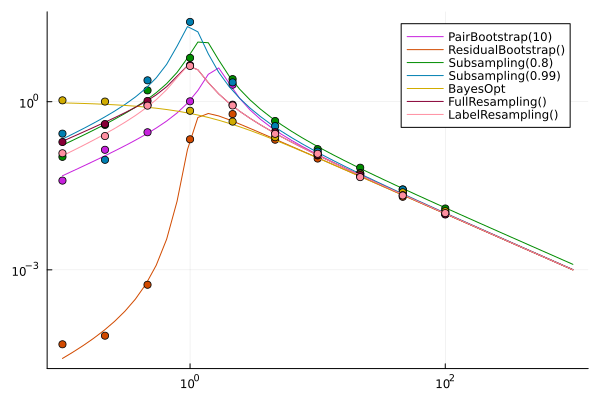

In [115]:
# load the overlaps from pairbootstrap file 

# define color for each algo
colors = distinguishable_colors(
    length(algos), [RGB(1, 1, 1), RGB(0, 0, 0)]; dropseed=true
)

pl = plot()
for i in eachindex(algos)
    algo = algos[i]
    f = open(filenames[algo], "r")
    data = JSON.parse(String(read(f)))
    close(f)

    f_exp = open(exp_filenames[algo], "r")
    data_exp = JSON.parse(String(read(f_exp)))
    close(f_exp)

    if algo != BayesOpt()
        variance = data["q_diag"] .- data["q_off_diag"]
    else 
        variance = 1.0 .- data["q_diag"]
    end
    scaling = 1.0
    if algo isa Subsampling
        scaling = 1.0 / (1.0 - data["proba"][1])
    end
    label = "$algo"
    if algo == BayesOpt()
        label = "BayesOpt"
    end
    plot!(alpha_range, variance .* scaling, yscale=:log10, xscale=:log10, label=label, color=colors[i])
    # put no label for the scatter
    scatter!(data_exp["alpha"], scaling * K / (K - 1) * data_exp["var"], label="", color=colors[i])
end

display(pl)

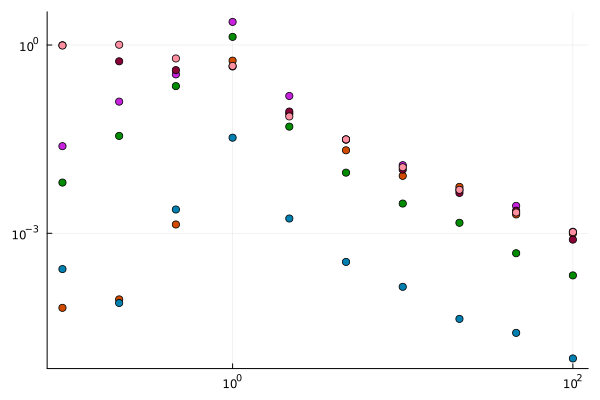

In [129]:
pl = plot(xaxis=:log10, yaxis=:log10)
for i in eachindex(algos)
    algo = algos[i]
    if algo == BayesOpt()
        continue
    end

    f_exp = open(exp_filenames[algo], "r")
    data_exp = JSON.parse(String(read(f_exp)))
    close(f_exp)

    scaling = 1.0
    # if algo isa Subsampling
    #     scaling = 1.0 ./ (1.0 .- data_exp["proba"])
    # end
    scatter!(data_exp["alpha"],  data_exp["bias"], label="", color=colors[i])
end

display(pl)